In [1]:
# DATA IMPORT, PREPROCESSING AND MANIPULATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
from datetime import datetime
import seaborn as sns
import tensorflow as tf

# MODEL IMPLEMENTATION
# ML
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# DL
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Model Implementation & Optimization

In [2]:
# MODEL IMPLEMENTATION
# -------------------------------------
# New variable for modularization
model_data = pd.read_csv('preprocessed.csv', header=0) # 1000 ROWS
model_data = model_data[['Bedrooms', 'SquareFootageHouse', 'Age', 'PoolQuality',
       'BathroomsQuality', 'LivingRoomsQuality', 'SquareFootageGarden',
       'PreviousOwnerRating', 'HeatingCosts', 'DaysSinceForSale', 'Price', 'HasPool']]
# Divide the data into features and target
X = model_data.drop('Price', axis=1)
y = model_data['Price']

# For later denormalization
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Transform the features
X_norm = scaler_X.fit_transform(X)
#y = scaler_y.fit_transform(y.reshape(-1, 1))
y_norm = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [3]:
# SIMPLE MODEL IMPLEMENTATION
# -------------------------------------
# Linear Regression
lr_model = LinearRegression()

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=0)

In [4]:
# COMPLEX MODEL IMPLEMENTATION
# -------------------------------------
# Random Forest
rf_model = RandomForestRegressor(random_state=0)

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=0)

In [5]:
# COMPLEX MODEL WITH HYPERPARAMETER TUNING
# -------------------------------------
# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid_search = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_norm, y_norm)
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best RMSE for Random Forest:", np.sqrt(-rf_grid_search.best_score_))

# Hyperparameter tuning for Gradient Boosting
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
gb_grid_search = GridSearchCV(gb_model, gb_params, cv=5, scoring='neg_mean_squared_error')
gb_grid_search.fit(X_norm, y_norm)
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)
print("Best RMSE for Gradient Boosting:", np.sqrt(-gb_grid_search.best_score_))

# FINAL MODEL IMPLEMENTATION
# Evaluate the best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

# Evaluate the best Gradient Boosting model
best_gb_model = gb_grid_search.best_estimator_

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE for Random Forest: 0.07193504284570248
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best RMSE for Gradient Boosting: 0.07081125375192132


In [6]:
# DEEP LEARNING MODEL IMPLEMENTATION
# -------------------------------------

def build_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

# Model Evaluation

In [7]:
# MACHINE LEARNING MODEL EVALUATION FUNCTION
# -------------------------------------
def evaluate_ml_model(name, model, X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = pd.DataFrame(X).iloc[train_index], pd.DataFrame(X).iloc[test_index]
        y_train, y_test = pd.Series(y).iloc[train_index], pd.Series(y).iloc[test_index]
        
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        r2_scores.append(r2_score(y_test, y_pred))
    
    print(f'    RMSE: {np.mean(rmse_scores)}')
    print(f'    MAE: {np.mean(mae_scores)}')
    print(f'    R²: {np.mean(r2_scores)}')
    return (name, np.mean(rmse_scores), np.mean(mae_scores), np.mean(r2_scores))


In [8]:
# DEEP LEARNING MODEL EVALUATION FUNCTION
# -------------------------------------

def evaluate_dl_model(name, model, pX_norm, py_norm):
    rmse_scores = []
    mae_scores = []
    r2_scores = []

    X_train, X_test, y_train, y_test = train_test_split(pX_norm, py_norm, test_size=0.2, random_state=0)

    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    y_pred = model.predict(X_test).flatten()

    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

    print(f'    RMSE: {np.mean(rmse_scores)}')
    print(f'    MAE: {np.mean(mae_scores)}')
    print(f'    R²: {np.mean(r2_scores)}')
    return (name, np.mean(rmse_scores), np.mean(mae_scores), np.mean(r2_scores), y_pred)


In [9]:
# SPECIFIC MODEL EVALUATION
# -------------------------------------
performance = []
# Linear Regression Evaluation
print("Linear Regression Evaluation:")
performance.append(evaluate_ml_model("LinearRegression", lr_model, X_norm, y_norm))

# Decision Tree Evaluation
print("\nDecision Tree Evaluation:")
performance.append(evaluate_ml_model("DecisionTreeRegressor", dt_model, X_norm, y_norm))

Linear Regression Evaluation:
    RMSE: 0.0656339637062287
    MAE: 0.020454215961876247
    R²: -0.007996404770974963

Decision Tree Evaluation:
    RMSE: 0.10479688237374236
    MAE: 0.029721227611186007
    R²: -1.9952330909123746


In [10]:
# Random Forest Evaluation
print("\nRandom Forest Evaluation:")
performance.append(evaluate_ml_model("RandomForestRegressor", rf_model, X_norm, y_norm))

# Gradient Boosting Evaluation
print("\nGradient Boosting Evaluation:")
performance.append(evaluate_ml_model("GradientBoostingRegressor", gb_model, X_norm, y_norm))


Random Forest Evaluation:
    RMSE: 0.07350720297562821
    MAE: 0.02591245429053498
    R²: -0.33815903478134474

Gradient Boosting Evaluation:
    RMSE: 0.07755994529033117
    MAE: 0.026434384524742373
    R²: -0.5230566253154154


In [11]:
# Best Random Forest Evaluation
print("\nBest Random Forest Model Evaluation:")
performance.append(evaluate_ml_model("BestRandromForest", best_rf_model, X_norm, y_norm))

# Best Gradient Boosting Evaluation
print("\nBest Gradient Boosting Model Evaluation:")
performance.append(evaluate_ml_model("BestGradientBoosting", best_gb_model, X_norm, y_norm))


Best Random Forest Model Evaluation:
    RMSE: 0.06805735181443696
    MAE: 0.023112539306464185
    R²: -0.116145895912145

Best Gradient Boosting Model Evaluation:
    RMSE: 0.06605275505815922
    MAE: 0.02034297766737003
    R²: -0.025039320932570552


In [12]:
# Deep learning Evaluation
print("\nDeep learning Model Evaluation:")

dl_model = build_model(X.shape[1])
(name, rmse, mae, r2, predicted_best_dl_prices) = evaluate_dl_model("DeepLearningModel", dl_model, X_norm, y_norm)
performance.append((name, rmse, mae, r2))


Deep learning Model Evaluation:
7/7 [==============================] - 0s 1ms/step
    RMSE: 0.08876693485413188
    MAE: 0.027666883045984383
    R²: -0.2765412027114236


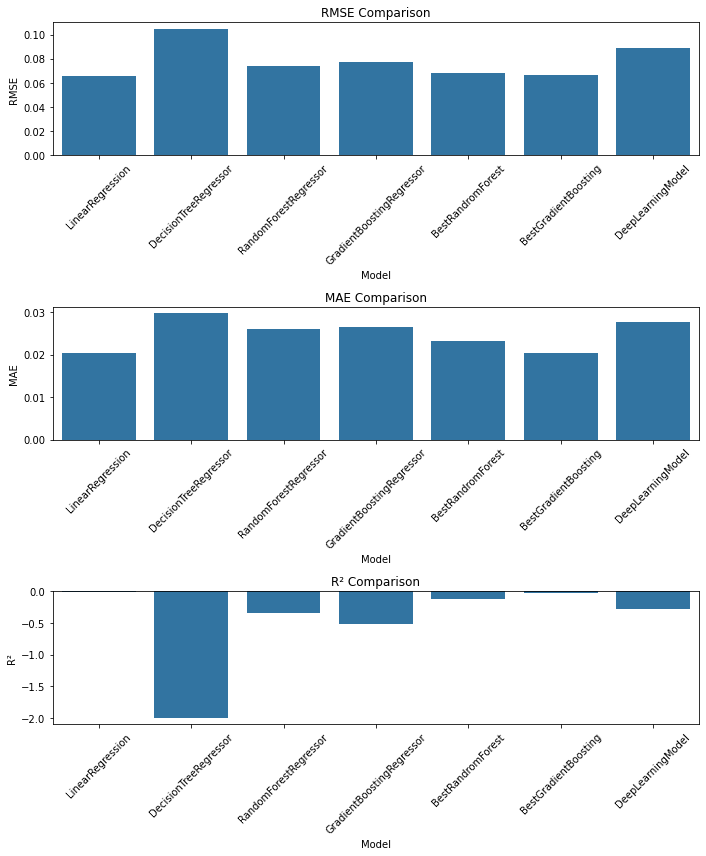

In [13]:
# MODEL PLOTING
# -------------------------------------
df_results = pd.DataFrame(performance, columns=['Model', 'RMSE', 'MAE', 'R²'])

plt.figure(figsize=(10, 12))

# RMSE Plot
plt.subplot(3, 1, 1)
sns.barplot(x='Model', y='RMSE', data=df_results)
plt.title('RMSE Comparison')
plt.xticks(rotation=45)

# MAE Plot
#print(df_results)

# LINEAR REGRESSION AND BEST GRADIENT BOOSTING ARE THE BEST 2 ONES
plt.subplot(3, 1, 2)
sns.barplot(x='Model', y='MAE', data=df_results)
plt.title('MAE Comparison')
plt.xticks(rotation=45)

# R² Plot
plt.subplot(3, 1, 3)
sns.barplot(x='Model', y='R²', data=df_results)
plt.title('R² Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [14]:
df_results

,Model,RMSE,MAE,R²
0,LinearRegression,0.065634,0.020454,-0.007996
1,DecisionTreeRegressor,0.104797,0.029721,-1.995233
2,RandomForestRegressor,0.073507,0.025912,-0.338159
3,GradientBoostingRegressor,0.077560,0.026434,-0.523057
4,BestRandromForest,0.068057,0.023113,-0.116146
5,BestGradientBoosting,0.066053,0.020343,-0.025039
6,DeepLearningModel,0.088767,0.027667,-0.276541


In [34]:
df_results[(df_results['RMSE'] == df_results['RMSE'].min()) | (df_results['MAE'] == df_results['MAE'].min())]

,Model,RMSE,MAE,R²
0,LinearRegression,0.065634,0.020454,-0.007996
5,BestGradientBoosting,0.066053,0.020343,-0.025039


# Prediction

In [16]:
X_norm.shape

(972, 11)

In [55]:
# If I have a budget of €100,000, what kind of houses will I be able to buy?
# -------------------------------------
# Predict house prices using the best models
predicted_rf_prices = rf_model.predict(X_norm)
predicted_best_rf_prices = best_rf_model.predict(X_norm)
predicted_best_gb_prices = best_gb_model.predict(X_norm)
predicted_dl_prices = dl_model.predict(X_norm)
predicted_lr_prices = lr_model.predict(X_norm)

# Denormalize the predicted prices
predicted_rf_prices = scaler_y.inverse_transform(predicted_rf_prices.reshape(-1, 1)).flatten()
predicted_best_rf_prices = scaler_y.inverse_transform(predicted_best_rf_prices.reshape(-1, 1)).flatten()
predicted_best_gb_prices = scaler_y.inverse_transform(predicted_best_gb_prices.reshape(-1, 1)).flatten()
predicted_dl_prices = scaler_y.inverse_transform(predicted_dl_prices.reshape(-1, 1)).flatten()
predicted_lr_prices = scaler_y.inverse_transform(predicted_lr_prices.reshape(-1, 1)).flatten()

# Create a DataFrame to store the features and predicted prices
predictions_df = X.copy()
predictions_df['Price'] = y.copy()
#predictions_df['Predicted_Price_Random_Forest'] = predicted_rf_prices
predictions_df['Predicted_Price_Best_Random_Forest'] = predicted_best_rf_prices
predictions_df['Predicted_Price_Linear_Regression'] = predicted_lr_prices
predictions_df['Predicted_Price_Best_Gradient_Boosting'] = predicted_best_gb_prices
#predictions_df['Predicted_Price_Deep_Learning'] = predicted_dl_prices

# Filter houses that can be bought within a budget of €100,000
#houses_within_random_forest_budget = predictions_df[predictions_df['Predicted_Price_Random_Forest'] <= 100]
#houses_within_best_random_forest_budget = predictions_df[predictions_df['Predicted_Price_Best_Random_Forest'] <= 100]
#houses_within_gradient_boosting_budget = predictions_df[predictions_df['Predicted_Price_Best_Gradient_Boosting'] <= 100]

# Print the houses that can be bought within a budget of €100,000
print("Houses that can be bought within a budget of €100,000:")
filtered_houses = predictions_df[
    ((50 <= predictions_df['Predicted_Price_Linear_Regression']) & predictions_df['Predicted_Price_Linear_Regression'] <= 150) |
    ((50 <= predictions_df['Predicted_Price_Best_Gradient_Boosting']) & (predictions_df['Predicted_Price_Best_Gradient_Boosting'] <= 150)) |
    ((50 <= predictions_df['Predicted_Price_Best_Random_Forest']) & (predictions_df['Predicted_Price_Best_Random_Forest'] <= 150))]

filtered_houses = predictions_df[
    (predictions_df['Predicted_Price_Linear_Regression'] <= 150) |
    (predictions_df['Predicted_Price_Best_Gradient_Boosting'] <= 150) |
    (predictions_df['Predicted_Price_Best_Random_Forest'] <= 100)]

filtered_houses

31/31 [==============================] - 0s 2ms/step
Houses that can be bought within a budget of €100,000:


,Bedrooms,SquareFootageHouse,Age,PoolQuality,BathroomsQuality,LivingRoomsQuality,SquareFootageGarden,PreviousOwnerRating,HeatingCosts,DaysSinceForSale,HasPool,Price,Predicted_Price_Best_Random_Forest,Predicted_Price_Linear_Regression,Predicted_Price_Best_Gradient_Boosting
16,1.0,36.0,54.0,0,0,1,14.0,1.84,56.000000,1137,1,60.47630,157.218298,145.040826,207.138883
36,1.0,30.0,0.0,-1,1,1,6.0,3.03,103.820000,632,0,61.91122,98.057287,286.598953,224.056005
98,1.0,41.0,70.0,-1,0,1,6.0,3.15,93.589996,308,0,173.23775,169.391329,137.930434,210.439078
115,1.0,22.0,57.0,-1,0,0,6.0,3.19,13.200000,820,0,141.84538,98.816002,178.060855,210.439078
137,1.0,44.0,37.0,-1,2,1,6.0,2.36,45.000000,491,0,56.12531,95.792931,263.214874,235.236696
143,1.0,35.0,52.0,-1,1,1,6.0,2.52,20.400000,1113,0,85.22168,99.875460,197.339666,205.646142
153,1.0,8457.0,66.0,-1,1,1,16.0,2.52,182.449997,996,0,259.88653,274.124384,122.656595,278.853660
160,2.0,60.0,0.0,-1,1,1,6.0,2.24,132.710007,1507,0,48.49086,93.556341,331.914751,222.939112
167,1.0,52.0,63.0,-1,0,1,6.0,1.71,646.559998,964,0,48.71951,96.389036,143.218974,191.300311
181,1.0,29.0,31.0,-1,1,2,6.0,2.58,44.800000,1051,0,41.50118,88.378103,209.897489,219.263068


In [59]:
# How much money can I save if I decide not to get a house with a pool?
# -------------------------------------
# Calculate the average predicted price for houses with a pool and without a pool
PRED_SUBSET = ['Predicted_Price_Best_Gradient_Boosting', 'Predicted_Price_Linear_Regression', 'Predicted_Price_Best_Random_Forest']

average_price_with_pool = predictions_df[predictions_df['HasPool'] == 1][PRED_SUBSET].mean().mean()
average_price_without_pool = predictions_df[predictions_df['HasPool'] == 0][PRED_SUBSET].mean().mean()

# Calculate the potential savings
savings_without_pool = average_price_with_pool - average_price_without_pool

# Print the potential savings
savings_without_pool

53.06632794032885

In [58]:
# How much money can I save if I decide not to get a house with a pool?
# -------------------------------------
# Calculate the average predicted price for houses with a pool and without a pool
average_price_with_pool = predictions_df[predictions_df['HasPool'] == 1]['Price'].mean()
average_price_without_pool = predictions_df[predictions_df['HasPool'] == 0]['Price'].mean()

# Calculate the potential savings
savings_without_pool = average_price_with_pool - average_price_without_pool

# Print the potential savings
savings_without_pool

46.27152064524313

In [57]:
# How much money can I save if I decide not to get a house with a pool?
# -------------------------------------
# Calculate the average predicted price for houses with a pool and without a pool
PRED_SUBSET = ['Predicted_Price_Linear_Regression', 'Predicted_Price_Best_Random_Forest', 'Predicted_Price_Best_Gradient_Boosting']

average_price_with_pool = predictions_df[predictions_df['HasPool'] == 1][PRED_SUBSET].mean().mean()
average_price_without_pool = predictions_df[predictions_df['HasPool'] == 0][PRED_SUBSET].mean().mean()

# Calculate the potential savings
savings_without_pool = average_price_with_pool - average_price_without_pool

# Print the potential savings
savings_without_pool

53.06632794032885